In [4]:
# Loan dataset prdecition using Logistic Regression with Pipeline
##import statements

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
# reading the dataset and creating train and test data
df= pd.read_csv("Loan_dataset.csv")

df = df.dropna(subset=["Loan_Status"])

X = df.drop(columns=["Loan_Status","Loan_ID","Gender","Dependents"])
y = df["Loan_Status"].map({"Y":1,"N":0})
print(y.shape)
print(y.isna().sum())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(614,)
0


In [6]:
# deciding all the columns which are getting used for prediction

log_cols = ["ApplicantIncome", "CoapplicantIncome"] 
num_cols = [ "LoanAmount", "Credit_History","Loan_Amount_Term"]
cat_cols = [ "Married", "Self_Employed","Education","Property_Area"]

In [15]:
# Check Credit_History values
print("Credit_History unique values:", X_train["Credit_History"].unique())
print("Credit_History min:", X_train["Credit_History"].min())
print("Credit_History max:", X_train["Credit_History"].max())

Credit_History unique values: [nan  1.  0. -1.]
Credit_History min: -1.0
Credit_History max: 1.0


In [10]:
# Creating pipelines 
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [17]:
# Applying pipeline on the model dataset
preprocessor = ColumnTransformer([
    ("log_num", log_numeric_pipeline, log_cols),
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

class DataSetValidator(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if (X["ApplicantIncome"] < 0).any():
            raise ValueError("ApplicantIncome cannot be negative")
        if (X["CoapplicantIncome"] < 0).any():
            raise ValueError("CoapplicantIncome cannot be negative")
        return X

model_pipeline = Pipeline([
    ("dataset_validation", DataSetValidator()),
    ("preprocess", preprocessor),
    ("model", LogisticRegression(class_weight="balanced"))
])

Accuracy: 0.7235772357723578


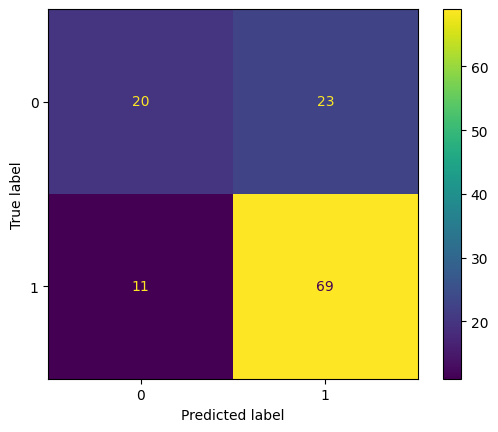

In [18]:
# training the model
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
test_data = {
    "Married": "No",
    "Education": "Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 50000,
    "CoapplicantIncome": 15000,
    "LoanAmount": 400,
    "Loan_Amount_Term": 360,
    "Credit_History": 1,
    "Property_Area": "Urban"
}
test_df = pd.DataFrame([test_data])
model = model_pipeline
prediction = model.predict(test_df)
print("Prediction:", prediction)
if prediction[0] == 1:
    print("Loan Approved ")
else:
    print("Loan Rejected ")

Prediction: [1]
Loan Approved 


In [ ]:
test_data = {
    "Loan_ID": "LP001999",
    "Gender": "Female",
    "Married": "No",
    "Dependents": "2",
    "Education": "Not Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 6500,
    "CoapplicantIncome": 1100,
    "LoanAmount": 20000,
    "Loan_Amount_Term": 360,
    "Credit_History": 3,
    "Property_Area": "Rural"
}
test_df = pd.DataFrame([test_data])
model = model_pipeline
prediction = model.predict(test_df)
print("Prediction:", prediction)
if prediction[0] == 1:
    print("Loan Approved ")
else:
    print("Loan Rejected ")

Prediction: [0]
Loan Rejected 


In [20]:
import joblib

# Save the trained model
joblib.dump(model_pipeline, "loan_model.pkl")
print("Model saved successfully!")

# Load the model
loaded_model = joblib.load("loan_model.pkl")
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!
